In [1]:
import json
import sys
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import scipy.stats as stats
import random
from scipy.stats import gaussian_kde, loguniform
from math import lgamma
from glob import glob
import os
#import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

path = '/Users/chris/Desktop/sculpting/'

In [2]:
berger_kepler = pd.read_csv(path+'berger_kepler_stellar17.csv') # crossmatched with Gaia via Bedell
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/envs/superflare/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# transit multiplicity from Kepler/Gaia Berger et al 2020, plus Bedell, plus Exoplanet Archive
# see isolate_with_bedell.ipynb
pnum = pd.read_csv(path+'pnum_plus_cands.csv')
print(len(pnum))
pnum = pnum.drop_duplicates(['kepid'])
print(len(pnum))
k = pnum.koi_count.value_counts() 
k = pd.Series([len(berger_kepler)-np.sum(k), 244, 51, 12, 8, 1]) 
print(k)

408
316
0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64


In [184]:
import csv
from ast import literal_eval

with open('simulations_w_geometric_transits.csv','r') as csvfile:
    read_csv = csv.reader(csvfile, delimiter='\t')
    read_csv=list(read_csv)

df = pd.DataFrame(read_csv[1:], columns=read_csv[0])
df.lams = df.lams.apply(literal_eval) # convert back from string to list of floats
df.geometric_lams = df.geometric_lams.apply(literal_eval)
df.logLs = df.logLs.apply(literal_eval)
df.geometric_logLs = df.geometric_logLs.apply(literal_eval)
df.bs = df.bs.apply(literal_eval)
df.ms = df.ms.apply(literal_eval)

df.intact_fracs = df.intact_fracs.apply(literal_eval)
geom_logLs = df.geometric_logLs
geom_lams = df.geometric_lams
logLs = df.logLs
lams = df.lams
print(df)

      ms   bs                                       intact_fracs  \
0   -1.0  0.0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   -1.0  0.1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   -1.0  0.2  [0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...   
3   -1.0  0.3  [0.0001001552406229656, 0.0001502328609344484,...   
4   -1.0  0.4  [0.0006510090640492763, 0.0004006209624918624,...   
..   ...  ...                                                ...   
116  0.0  0.6  [0.5964244579097602, 0.6007812108768591, 0.596...   
117  0.0  0.7  [0.6946266713405779, 0.7012369172216937, 0.696...   
118  0.0  0.8  [0.8031448745555612, 0.8018428564274626, 0.799...   
119  0.0  0.9  [0.9013971656066904, 0.8966397916770995, 0.902...   
120  0.0  1.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   

                                                 logLs  \
0    [-861.3326564321698, -825.8876440117946, -825....   
1    [-799.328925833771, -777.0103471419387, -803.7...   
2    [-80

In [94]:
# if lams==1e-12, set logL to 0
def better_loglike(lam, k, flag):
    """
    Calculate Poisson log likelihood
    """
    
    logL = []
    #lam = lam.to_list() # to bypass indexing for testing
    for i in range(len(lam)):
        if flag=='a': # control
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)
            
        elif flag=='b': # append zero to logL
            if lam[i]==1e-12:
                logL.append(0)
                #print("hi")
            else:
                term3 = -lgamma(k[i]+1)
                term2 = -lam[i]
                term1 = k[i]*np.log(lam[i])
                #print(term3, term2, term1)
                logL.append(term1+term2+term3)
        
        elif flag=='c': # replace zero lam with another value approximating zero
            temp_lam = lam
            if lam[i]==1e-12:
                temp_lam[i] = 1
                
            term3 = -lgamma(k[i]+1)
            term2 = -temp_lam[i]
            term1 = k[i]*np.log(temp_lam[i])
            logL.append(term1+term2+term3)
            
        elif flag=='d': # turn log term to 0
            if lam[i]==1e-12:    
                term3 = -lgamma(k[i]+1)
                term2 = -lam[i]
                term1 = 0
                logL.append(term1+term2+term3)
                
            else:
                term3 = -lgamma(k[i]+1)
                term2 = -lam[i]
                term1 = k[i]*np.log(lam[i])
                logL.append(term1+term2+term3)
                
        #print(lam[i])
        #print(logL)
    return np.sum(logL)

In [130]:
# high initial; low decline
print(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 1)].lams.to_list()[0][0], k, 'c'))


[18311.0, 844.0, 442.0, 232.0, 106.0, 28.0]
-929.0915782056396
-929.0915782056396
-929.0915782056396


In [131]:
# low initial; no decline
print(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == 0) & (df.bs == 0)].lams.to_list()[0][0], k, 'c'))

[19215.0, 712.0, 42.0, 1e-12, 1e-12, 1e-12]
-835.8140723635021
-224.9708115305924
-304.2169158818745


In [8]:
# low initial; fast decline
print(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'c'))


[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12]
-861.3326564321698
-250.4893955992601
-284.0812129976672


In [9]:
# high initial; fast decline
print(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 1)].lams.to_list()[0][0], k, 'c'))

[19211.0, 688.0, 56.0, 8.0, 5.0, 1.0]
-215.5201800205563
-215.5201800205563
-215.5201800205563


In [10]:
# multimodal population
print(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'a'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'b'))
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0.6)].lams.to_list()[0][0], k, 'c'))

[19232.0, 695.0, 42.0, 1e-12, 1e-12, 1e-12]
-824.3307697249828
-213.48750889207315
-247.07932629048028


### Young vs old systems

Do I get more multis in young systems versus old ones? It should be no difference for b=0 case, but more multis in young for cases that don't decay to P(intact)=0 so quickly from a high enough b. 

In [11]:
# pick two CSVs from five different cases: 
# b = 0; m = 0 
# b = 0; m = -0.5; distribution of planets and transits should be same as above
# m = -1; b = 0
# m = -1; b = 0.5; should be slightly shallower than above
# m = -0.5; b = 1; should be shallower than above

# split each datafrmae into young and old

# for each, plot transit multiplicity and num_planets plots

In [12]:
a = pd.read_csv('young_old_test_data/transits0_0_1.csv')
b = pd.read_csv('young_old_test_data/transits5_0_1.csv')
a.planet_inclinations = a.planet_inclinations.apply(literal_eval)
a['num_planets'] = a.planet_inclinations.str.len()
b['num_planets'] = b.planet_inclinations.str.len()
a_young = a.loc[a.star_ages <= 1.]
a_old = a.loc[a.star_ages > 1.]
b_young = b.loc[b.star_ages <= 1.]
b_old = b.loc[b.star_ages > 1.]

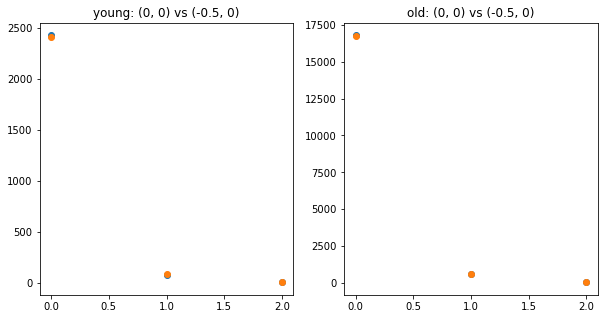

0    2430
1      79
2       5
Name: transit_multiplicity, dtype: int64
0    2418
1      90
2       6
Name: transit_multiplicity, dtype: int64
0    16782
1      618
2       55
Name: transit_multiplicity, dtype: int64
0    16764
1      648
2       43
Name: transit_multiplicity, dtype: int64


In [13]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
ax.scatter(a_young.transit_multiplicity.value_counts().index, a_young.transit_multiplicity.value_counts())
ax.scatter(b_young.transit_multiplicity.value_counts().index, b_young.transit_multiplicity.value_counts())
ax.set_title('young: (0, 0) vs (-0.5, 0)')

ax = axes[1]
ax.scatter(a_old.transit_multiplicity.value_counts().index, a_old.transit_multiplicity.value_counts())
ax.scatter(b_old.transit_multiplicity.value_counts().index, b_old.transit_multiplicity.value_counts())
ax.set_title('old: (0, 0) vs (-0.5, 0)')
plt.show()

print(a_young.transit_multiplicity.value_counts())
print(b_young.transit_multiplicity.value_counts())
print(a_old.transit_multiplicity.value_counts())
print(b_old.transit_multiplicity.value_counts())

In [26]:
a = pd.read_csv('young_old_test_data/transits10_0_1.csv')
b = pd.read_csv('young_old_test_data/transits10_10_1.csv')
a.planet_inclinations = a.planet_inclinations.apply(literal_eval)
a['num_planets'] = a.planet_inclinations.str.len()
b['num_planets'] = b.planet_inclinations.str.len()
a_young = a.loc[a.star_ages <= 1.]
a_old = a.loc[a.star_ages > 1.]
b_young = b.loc[b.star_ages <= 1.]
b_old = b.loc[b.star_ages > 1.]

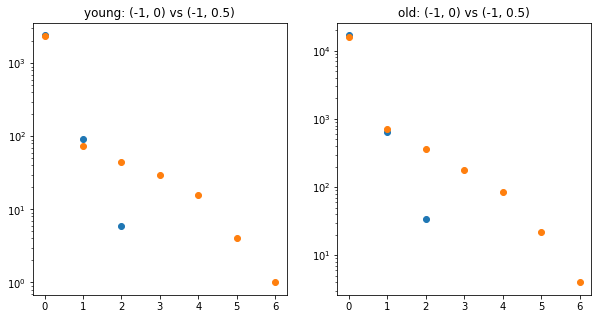

0    2416
1      92
2       6
Name: transit_multiplicity, dtype: int64
0    2344
1      74
2      45
3      30
4      16
5       4
6       1
Name: transit_multiplicity, dtype: int64
0    16782
1      639
2       34
Name: transit_multiplicity, dtype: int64
0    16103
1      706
2      357
3      178
4       85
5       22
6        4
Name: transit_multiplicity, dtype: int64


In [27]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
#ax.scatter(a_young.transit_multiplicity.value_counts().index[1:], a_young.transit_multiplicity.value_counts()[1:])
#ax.scatter(b_young.transit_multiplicity.value_counts().index[1:], b_young.transit_multiplicity.value_counts()[1:])
ax.scatter(a_young.transit_multiplicity.value_counts().index, a_young.transit_multiplicity.value_counts())
ax.scatter(b_young.transit_multiplicity.value_counts().index, b_young.transit_multiplicity.value_counts())
ax.set_yscale('log')
ax.set_title('young: (-1, 0) vs (-1, 0.5)')

ax = axes[1]
#ax.scatter(a_old.transit_multiplicity.value_counts().index[1:], a_old.transit_multiplicity.value_counts()[1:])
#ax.scatter(b_old.transit_multiplicity.value_counts().index[1:], b_old.transit_multiplicity.value_counts()[1:])
ax.scatter(a_old.transit_multiplicity.value_counts().index, a_old.transit_multiplicity.value_counts())
ax.scatter(b_old.transit_multiplicity.value_counts().index, b_old.transit_multiplicity.value_counts())
ax.set_title('old: (-1, 0) vs (-1, 0.5)')
ax.set_yscale('log')
plt.show()

print(a_young.transit_multiplicity.value_counts())
print(b_young.transit_multiplicity.value_counts())
print(a_old.transit_multiplicity.value_counts())
print(b_old.transit_multiplicity.value_counts())

In [16]:
a.loc[a.star_ages < 0.5] # these are the stars with non-zero P(intact) in the (-1, 0.5) case; ~1% of FGK stars

,Unnamed: 0,star_ages,planet_periods,semi_major_axes,midplane,midplane_degrees,planet_inclinations,planet_inclinations_degrees,impact_parameters,transit_status,...,geometric_transit_multiplicity,transit_multiplicity,kepid,y_intercept,slope,transit_duration,6hr_cdpp,signal_noise,prob_detections,num_planets
68,68,0.27,"[2.8294786219000576, 84.47819810665194]","[0.04198754923571957, 0.40409115342767477]",-0.661361,[-37.89318956100635],"[-0.7652379246387775, -0.6413786463921003]","[-43.8449034051521, -36.74828950808097]","[-5.255659818115834, -43.68727657264353]","[0, 0]",...,0,0,1571732,0.0,0.0,[nan nan],134.900,[nan nan],[0. 0.],2
93,93,0.26,"[288.57028866019624, 3.097414759230565]","[0.899640965201117, 0.04377583000493698]",-0.545320,[-31.244524254530816],"[-0.9009829902385794, -0.4757126465435172]","[-51.62252275374725, -27.256326907942224]","[-136.8718173654081, -3.890780473697813]","[0, 0]",...,0,0,1718753,0.0,0.0,[nan nan],44.813,[nan nan],[0. 0.],2
111,111,0.46,"[44.831786479515834, 12.22378041277312]","[0.26784617564763114, 0.11262421565862042]",0.565186,[32.3827653326253],"[0.33037670810554864, 0.4924277779715046]","[18.92919102387347, 28.214033392772382]","[14.82852740518595, 9.08680320116332]","[0, 0]",...,0,0,1722816,0.0,0.0,[nan nan],85.155,[nan nan],[0. 0.],2
217,217,0.35,"[11.933548107462059, 63.77283406040967]","[0.112964687014667, 0.3452922171663]",-0.851975,[-48.81456578272122],"[-0.7881421393754889, -0.9587825283968369]","[-45.15721824262702, -54.93419234802075]","[-13.097652887450533, -46.21457360450341]","[0, 0]",...,0,0,2019761,0.0,0.0,[nan nan],163.566,[nan nan],[0. 0.],2
430,430,0.48,"[8.637508454140505, 211.2731279521151]","[0.0923944440193923, 0.7785437828607992]",-0.053951,[-3.091186328823561],"[-0.26253236309809924, -0.11480647116837786]","[-15.041996391117165, -6.57792625873842]","[-3.6856470335636007, -13.708196812959486]","[0, 0]",...,0,0,2452289,0.0,0.0,[nan nan],55.937,[nan nan],[0. 0.],2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19433,19433,0.30,[5.992968857598368],[0.06967617501935994],-0.475594,[-27.249535380574798],[-0.693924560373012],[-39.75894860984468],[-7.90615711989548],[0],...,0,0,12024098,0.0,0.0,[nan],35.270,[nan],[0.],1
19517,19517,0.29,[60.29508759644653],[0.32643454685336337],0.737793,[42.272414434288116],[0.864542578806873],[49.5346409749902],[43.346909422349015],[0],...,0,0,12107925,0.0,0.0,[nan],31.147,[nan],[0.],1
19658,19658,0.47,[101.06655404886868],[0.43276103800691923],1.033363,[59.20736085307121],[1.0037609446435065],[57.511265768137584],[78.49370512251068],[0],...,0,0,12215836,0.0,0.0,[nan],57.862,[nan],[0.],1
19672,19672,0.25,[53.627781090484],[0.2970176597029675],-0.479058,[-27.448025769399393],[-0.22183004404869122],[-12.709925293191151],[-12.03081900142994],[0],...,0,0,12251653,0.0,0.0,[nan],54.232,[nan],[0.],1


In [17]:
df = pd.read_csv('young_old_test_data/transits5_10_1.csv')
df.planet_inclinations = df.planet_inclinations.apply(literal_eval)
df['num_planets'] = df.planet_inclinations.str.len()
df_young = df.loc[a.star_ages <= 1.]
df_old = df.loc[df.star_ages > 1.]

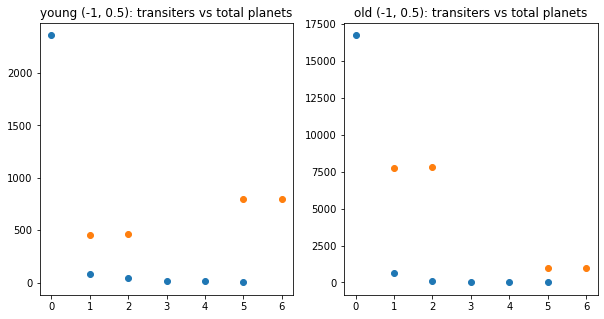

0    2359
1      81
2      42
3      17
4      14
5       1
Name: transit_multiplicity, dtype: int64
5    802
6    796
2    465
1    451
Name: num_planets, dtype: int64
0    16739
1      614
2       76
3       16
4        8
5        2
Name: transit_multiplicity, dtype: int64
2    7795
1    7735
6     974
5     951
Name: num_planets, dtype: int64


In [18]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=[10,5])
ax = axes[0]
ax.scatter(df_young.transit_multiplicity.value_counts().index, df_young.transit_multiplicity.value_counts())
ax.scatter(df_young.num_planets.value_counts().index, df_young.num_planets.value_counts())
ax.set_title('young (-1, 0.5): transiters vs total planets')

ax = axes[1]
ax.scatter(df_old.transit_multiplicity.value_counts().index, df_old.transit_multiplicity.value_counts())
ax.scatter(df_old.num_planets.value_counts().index, df_old.num_planets.value_counts())
ax.set_title('old (-1, 0.5): transiters vs total planets')
plt.show()

print(df_young.transit_multiplicity.value_counts())
print(df_young.num_planets.value_counts())
print(df_old.transit_multiplicity.value_counts())
print(df_old.num_planets.value_counts())

### Investigate different 0-lam treatments

Don't run this after Young vs Old because I goofed and reassigned the 'df' variable

In [6]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-861.3326564321698, -825.8876440117946, -825....","[[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...","[[18627.0, 1223.0, 119.0, 1e-12, 1e-12, 1e-12]...","[-1261.4969915537633, -1250.2596228659804, -12..."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-799.328925833771, -777.0103471419387, -803.7...","[[19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], ...","[[18690.0, 1166.0, 113.0, 1e-12, 1e-12, 1e-12]...","[-1209.4231169020752, -1219.629124541648, -125..."
2,-1.0,0.2,"[0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...","[-805.1386708963076, -827.6047739947156, -832....","[[19255.0, 667.0, 47.0, 1e-12, 1e-12, 1e-12], ...","[[18638.0, 1207.0, 124.0, 1e-12, 1e-12, 1e-12]...","[-1251.0086758749592, -1220.2300831235755, -12..."
3,-1.0,0.3,"[0.0001001552406229656, 0.0001502328609344484,...","[-808.4876059606244, -822.7657963210123, -816....","[[19243.0, 672.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[[18684.0, 1157.0, 128.0, 1e-12, 1e-12, 1e-12]...","[-1211.2671824864144, -1244.2059895874816, -12..."
4,-1.0,0.4,"[0.0006510090640492763, 0.0004006209624918624,...","[-477.2874397003105, -788.1722031988063, -773....","[[19251.0, 671.0, 46.0, 1.0, 1e-12, 1e-12], [1...","[[18618.0, 1204.0, 146.0, 1.0, 1e-12, 1e-12], ...","[-932.8145577654657, -1209.7027296547874, -120..."
...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.5964244579097602, 0.6007812108768591, 0.596...","[-502.3173500269684, -558.7062623889922, -520....","[[18794.0, 701.0, 271.0, 123.0, 61.0, 15.0], [...","[[18127.0, 963.0, 376.0, 216.0, 188.0, 78.0], ...","[-1083.8886428193034, -1138.0793238613696, -11..."
117,0.0,0.7,"[0.6946266713405779, 0.7012369172216937, 0.696...","[-620.6107843375355, -579.68334728838, -591.55...","[[18663.0, 725.0, 308.0, 176.0, 79.0, 16.0], [...","[[18004.0, 909.0, 418.0, 297.0, 226.0, 101.0],...","[-1227.8254671542775, -1200.6712207379887, -11..."
118,0.0,0.8,"[0.8031448745555612, 0.8018428564274626, 0.799...","[-710.0745076737753, -699.3343845145812, -608....","[[18563.0, 726.0, 371.0, 183.0, 93.0, 27.0], [...","[[17908.0, 857.0, 483.0, 322.0, 248.0, 124.0],...","[-1324.9824728296974, -1348.7435038027836, -12..."
119,0.0,0.9,"[0.9013971656066904, 0.8966397916770995, 0.902...","[-784.2720195137433, -766.9538395706194, -838....","[[18475.0, 780.0, 390.0, 197.0, 96.0, 27.0], [...","[[17736.0, 891.0, 510.0, 376.0, 272.0, 149.0],...","[-1491.6045251895155, -1456.4168055744135, -15..."


Based on troubleshooting above, I should treat 1e-12 lams by assigning 0's to corresponding logLs 

In [41]:
def og_better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    """
    
    logL = []
    #print(lam)
    for i in range(len(lam)):
        term3 = -lgamma(k[i]+1)
        #print(lam[i], k[i])
        term2 = -lam[i]
        term1 = k[i]*np.log(lam[i])
        logL.append(term1+term2+term3)
    return np.sum(logL)

In [44]:
k

0    19653
1      244
2       51
3       12
4        8
5        1
dtype: int64

In [51]:
np.sum(k)

19969

In [54]:
np.sum([19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12])

19969.0

In [55]:
og_better_loglike([19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], k)

-799.328925833771

In [32]:
better_loglike([19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], k, 'b')

-188.48566500086136

In [124]:
# reconstructive surgery for lam of 1e-12 
fixed_logLs = []
for x in df.lams:
    temp_fixed_logLs = []
    for y in x:
        temp_fixed_logLs.append(better_loglike(y, k, 'a'))
        #temp_fixed_logLs.append(og_better_loglike(y, k)) # for testing porpoises
    fixed_logLs.append(temp_fixed_logLs)
df['fixed_logLs'] = fixed_logLs

In [125]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,lams_nonzero,logLs_nonzero,mean_intact_fracs,fixed_logLs
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-861.3326564321698, -825.8876440117946, -825....","[[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...","[[18627.0, 1223.0, 119.0, 1e-12, 1e-12, 1e-12]...","[-1261.4969915537633, -1250.2596228659804, -12...","[[749.0, 42.0, 1e-12, 1e-12, 1e-12], [697.0, 6...","[-269.38485861950994, -234.75110823126832, -23...",0.000000,"[-861.3326564321698, -825.8876440117946, -825...."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-799.328925833771, -777.0103471419387, -803.7...","[[19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], ...","[[18690.0, 1166.0, 113.0, 1e-12, 1e-12, 1e-12]...","[-1209.4231169020752, -1219.629124541648, -125...","[[656.0, 39.0, 1e-12, 1e-12, 1e-12], [623.0, 4...","[-209.51344467519354, -187.68825932508096, -21...",0.000000,"[-799.328925833771, -777.0103471419387, -803.7..."
2,-1.0,0.2,"[0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...","[-805.1386708963076, -827.6047739947156, -832....","[[19255.0, 667.0, 47.0, 1e-12, 1e-12, 1e-12], ...","[[18638.0, 1207.0, 124.0, 1e-12, 1e-12, 1e-12]...","[-1251.0086758749592, -1220.2300831235755, -12...","[[667.0, 47.0, 1e-12, 1e-12, 1e-12], [696.0, 3...","[-214.94002223953808, -237.06861725314067, -24...",0.000010,"[-805.1386708963076, -827.6047739947156, -832...."
3,-1.0,0.3,"[0.0001001552406229656, 0.0001502328609344484,...","[-808.4876059606244, -822.7657963210123, -816....","[[19243.0, 672.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[[18684.0, 1157.0, 128.0, 1e-12, 1e-12, 1e-12]...","[-1211.2671824864144, -1244.2059895874816, -12...","[[672.0, 54.0, 1e-12, 1e-12, 1e-12], [692.0, 4...","[-218.03709966773684, -232.18649579964122, -22...",0.000081,"[-808.4876059606244, -822.7657963210123, -816...."
4,-1.0,0.4,"[0.0006510090640492763, 0.0004006209624918624,...","[-477.2874397003105, -788.1722031988063, -773....","[[19251.0, 671.0, 46.0, 1.0, 1e-12, 1e-12], [1...","[[18618.0, 1204.0, 146.0, 1.0, 1e-12, 1e-12], ...","[-932.8145577654657, -1209.7027296547874, -120...","[[671.0, 46.0, 1.0, 1e-12, 1e-12], [640.0, 58....","[-218.5779404881279, -198.29749256198883, -184...",0.000415,"[-477.2874397003105, -788.1722031988063, -773...."
...,...,...,...,...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.5964244579097602, 0.6007812108768591, 0.596...","[-502.3173500269684, -558.7062623889922, -520....","[[18794.0, 701.0, 271.0, 123.0, 61.0, 15.0], [...","[[18127.0, 963.0, 376.0, 216.0, 188.0, 78.0], ...","[-1083.8886428193034, -1138.0793238613696, -11...","[[701.0, 271.0, 123.0, 61.0, 15.0], [724.0, 29...","[-477.11708344989785, -530.2690308215658, -493...",0.600252,"[-502.3173500269684, -558.7062623889922, -520...."
117,0.0,0.7,"[0.6946266713405779, 0.7012369172216937, 0.696...","[-620.6107843375355, -579.68334728838, -591.55...","[[18663.0, 725.0, 308.0, 176.0, 79.0, 16.0], [...","[[18004.0, 909.0, 418.0, 297.0, 226.0, 101.0],...","[-1227.8254671542775, -1200.6712207379887, -11...","[[725.0, 308.0, 176.0, 79.0, 16.0], [726.0, 31...","[-588.9433689315335, -550.0418801407568, -561....",0.699880,"[-620.6107843375355, -579.68334728838, -591.55..."
118,0.0,0.8,"[0.8031448745555612, 0.8018428564274626, 0.799...","[-710.0745076737753, -699.3343845145812, -608....","[[18563.0, 726.0, 371.0, 183.0, 93.0, 27.0], [...","[[17908.0, 857.0, 483.0, 322.0, 248.0, 124.0],...","[-1324.9824728296974, -1348.7435038027836, -12...","[[726.0, 371.0, 183.0, 93.0, 27.0], [775.0, 33...","[-672.8193456746035, -662.372104505843, -578.1...",0.800016,"[-710.0745076737753, -699.3343845145812, -608...."
119,0.0,0.9,"[0.9013971656066904, 0.8966397916770995, 0.902...","[-784.2720195137433, -766.9538395706194, -838....","[[18475.0, 780.0, 390.0, 197.0, 96.0, 27.0], [...","[[17736.0, 891.0, 510.0, 376.0, 272.0, 149.0],...","[-1491.6045251895155, -1456.4168055744135, -15...","[[780.0, 390.0, 197.0, 96.0, 27.0], [775.0, 36...","[-741.62805388944

In [40]:
print(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0])
print(better_loglike(df.loc[(df.ms == -1) & (df.bs == 0)].lams.to_list()[0][0], k, 'a'))

[19178.0, 749.0, 42.0, 1, 1, 1]
-284.0812129976672


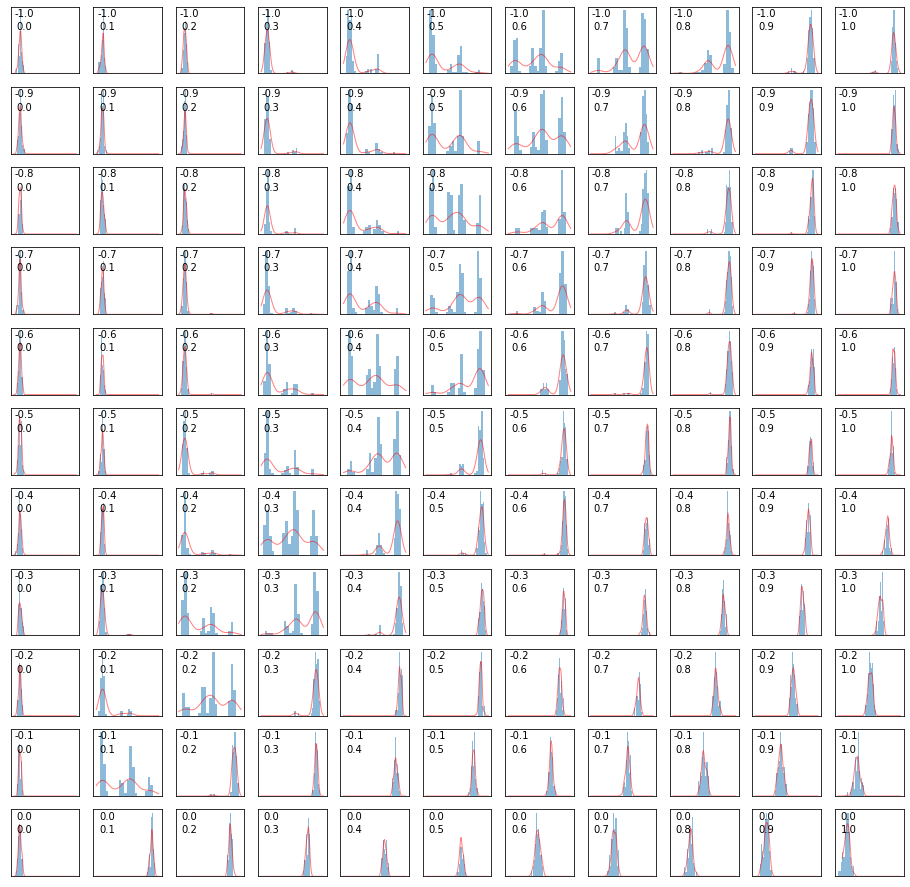

In [126]:
def kde_func(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    kde = gaussian_kde(x) # constant bandwidth so imbalance in sample size doesn't drive distribution
    return kde.evaluate(x_grid)

def prior_grid(cube, ndim, nparams, gi_m, gi_b):
    """
    Each model run will use an evenly spaced (m,b) tuple on a discrete 11x11 grid
    Does that ruin the point of multinest? Is it valid without random sampling? 
    Maybe so, but pymultinest keeps getting stuck, so I need to get a better sense of the logL surface.
    gi_m: grid index on m axis
    gi_b: grid index on b axis
    """
    cube[0] = np.linspace(-1,0,11)[gi_m]
    cube[1] = np.linspace(0,1,11)[gi_b]
    return cube

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    #print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    #print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 20
nparams = 2
draws = 50
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
logLs = df.fixed_logLs
lams = df.lams
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        cube = [random.uniform(0,1), random.uniform(0,1)]
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        ax.text(0.2, 0.9, round(cube[0],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, round(cube[1],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=20)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

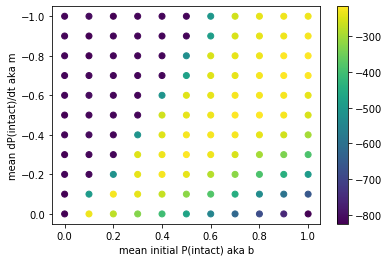

In [127]:
plt.scatter(bs, ms, c=mean_logLs)
plt.xlabel('mean initial P(intact) aka b')
plt.ylabel('mean dP(intact)/dt aka m')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

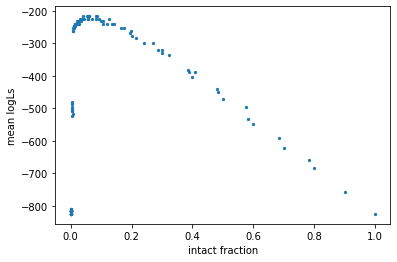

In [128]:
df.loc[:, "mean_intact_fracs"] = df.intact_fracs.apply(lambda x: np.mean(x))
plt.scatter(df.mean_intact_fracs, mean_logLs, s=5)
plt.ylabel('mean logLs')
plt.xlabel('intact fraction')
#plt.xlim(0, 0.1)
plt.show()

After "fixing" the logLs for lams==1e-12, there seems to be no more of the peak logL intact fraction that we've been expecting

### Nonzero bins only

In [185]:
### re-introduce nonzero-bin transit multiplicities
df_lams_nonzero = []
for x in df.lams:
    df_lams_nonzero.append([y[1:] for y in x])
df['lams_nonzero'] = df_lams_nonzero

In [186]:
df_logLs_nonzero = []
for x in df.lams_nonzero:
    temp_logLs_nonzero = []
    for y in x:
        #print(y, k[1:])
        temp_logLs_nonzero.append(better_loglike(y, k[1:].reset_index()[0], 'd'))
    df_logLs_nonzero.append(temp_logLs_nonzero)
df['logLs_nonzero'] = df_logLs_nonzero

In [187]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,lams_nonzero,logLs_nonzero
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-861.3326564321698, -825.8876440117946, -825....","[[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...","[[18627.0, 1223.0, 119.0, 1e-12, 1e-12, 1e-12]...","[-1261.4969915537633, -1250.2596228659804, -12...","[[749.0, 42.0, 1e-12, 1e-12, 1e-12], [697.0, 6...","[-269.38485861950994, -234.75110823126832, -23..."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-799.328925833771, -777.0103471419387, -803.7...","[[19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], ...","[[18690.0, 1166.0, 113.0, 1e-12, 1e-12, 1e-12]...","[-1209.4231169020752, -1219.629124541648, -125...","[[656.0, 39.0, 1e-12, 1e-12, 1e-12], [623.0, 4...","[-209.51344467519354, -187.68825932508096, -21..."
2,-1.0,0.2,"[0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...","[-805.1386708963076, -827.6047739947156, -832....","[[19255.0, 667.0, 47.0, 1e-12, 1e-12, 1e-12], ...","[[18638.0, 1207.0, 124.0, 1e-12, 1e-12, 1e-12]...","[-1251.0086758749592, -1220.2300831235755, -12...","[[667.0, 47.0, 1e-12, 1e-12, 1e-12], [696.0, 3...","[-214.94002223953808, -237.06861725314067, -24..."
3,-1.0,0.3,"[0.0001001552406229656, 0.0001502328609344484,...","[-808.4876059606244, -822.7657963210123, -816....","[[19243.0, 672.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[[18684.0, 1157.0, 128.0, 1e-12, 1e-12, 1e-12]...","[-1211.2671824864144, -1244.2059895874816, -12...","[[672.0, 54.0, 1e-12, 1e-12, 1e-12], [692.0, 4...","[-218.03709966773684, -232.18649579964122, -22..."
4,-1.0,0.4,"[0.0006510090640492763, 0.0004006209624918624,...","[-477.2874397003105, -788.1722031988063, -773....","[[19251.0, 671.0, 46.0, 1.0, 1e-12, 1e-12], [1...","[[18618.0, 1204.0, 146.0, 1.0, 1e-12, 1e-12], ...","[-932.8145577654657, -1209.7027296547874, -120...","[[671.0, 46.0, 1.0, 1e-12, 1e-12], [640.0, 58....","[-218.5779404881279, -198.29749256198883, -184..."
...,...,...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.5964244579097602, 0.6007812108768591, 0.596...","[-502.3173500269684, -558.7062623889922, -520....","[[18794.0, 701.0, 271.0, 123.0, 61.0, 15.0], [...","[[18127.0, 963.0, 376.0, 216.0, 188.0, 78.0], ...","[-1083.8886428193034, -1138.0793238613696, -11...","[[701.0, 271.0, 123.0, 61.0, 15.0], [724.0, 29...","[-477.11708344989785, -530.2690308215658, -493..."
117,0.0,0.7,"[0.6946266713405779, 0.7012369172216937, 0.696...","[-620.6107843375355, -579.68334728838, -591.55...","[[18663.0, 725.0, 308.0, 176.0, 79.0, 16.0], [...","[[18004.0, 909.0, 418.0, 297.0, 226.0, 101.0],...","[-1227.8254671542775, -1200.6712207379887, -11...","[[725.0, 308.0, 176.0, 79.0, 16.0], [726.0, 31...","[-588.9433689315335, -550.0418801407568, -561...."
118,0.0,0.8,"[0.8031448745555612, 0.8018428564274626, 0.799...","[-710.0745076737753, -699.3343845145812, -608....","[[18563.0, 726.0, 371.0, 183.0, 93.0, 27.0], [...","[[17908.0, 857.0, 483.0, 322.0, 248.0, 124.0],...","[-1324.9824728296974, -1348.7435038027836, -12...","[[726.0, 371.0, 183.0, 93.0, 27.0], [775.0, 33...","[-672.8193456746035, -662.372104505843, -578.1..."
119,0.0,0.9,"[0.9013971656066904, 0.8966397916770995, 0.902...","[-784.2720195137433, -766.9538395706194, -838....","[[18475.0, 780.0, 390.0, 197.0, 96.0, 27.0], [...","[[17736.0, 891.0, 510.0, 376.0, 272.0, 149.0],...","[-1491.6045251895155, -1456.4168055744135, -15...","[[780.0, 390.0, 197.0, 96.0, 27.0], [775.0, 36...","[-741.6280538894414, -725.6361861578342, -791...."


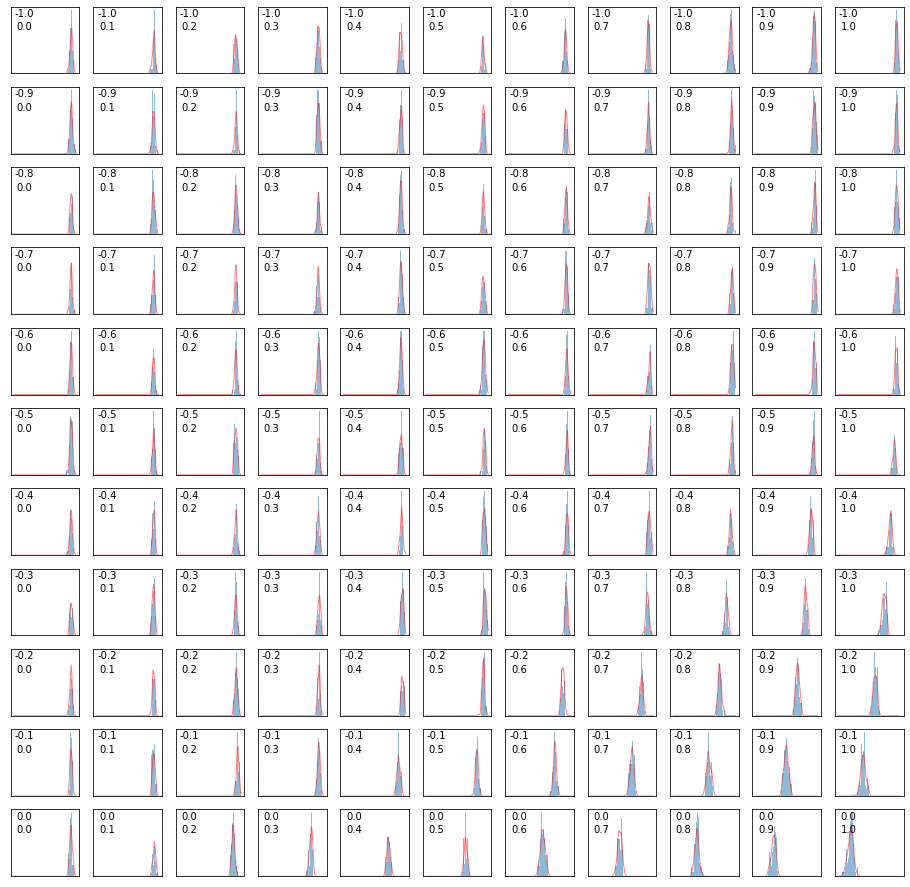

In [188]:
plt.figure(figsize=(16,16))
index = 0
ndim = 2
nbins = 20
nparams = 2
draws = 50
lower = min([min(i) for i in logLs])
upper = max([max(i) for i in logLs])
logLs = df.logLs_nonzero
lams = df.lams_nonzero
bs = df.bs
ms = df.ms
mean_logLs = []
mean_logLs2 = []
for gi_m in range(11):
    for gi_b in range(11):
        ax = plt.subplot2grid((11,11), (gi_m,gi_b))
        cube = [random.uniform(0,1), random.uniform(0,1)]
        cube = prior_grid(cube, ndim, nparams, gi_m, gi_b)
        ax.text(0.2, 0.9, round(cube[0],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.2, 0.7, round(cube[1],1), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        hist, bins = np.histogram(logLs[index], bins=30)
        
        x_grid = np.linspace(lower, upper, 100)
        kdepdf = kde_func(np.array(logLs[index]), x_grid, bandwidth=0.2) # generate KDE model
        mean_logLs.append(x_grid[np.argmax(kdepdf)])
        mean_logLs2.append(np.mean(logLs[index]))
        #random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
        #print(kdepdf)
        
        bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
        random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from histogram
        
        #plt.hist(logLs[index], bins=np.linspace(lower, upper, 20))
        ax.hist(logLs[index], nbins, density=True, alpha=0.5) # plot histogram of normalized data
        ax.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=1) # plot KDE over normalized histogram
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        index += 1
plt.show()

In [111]:
# to better show color differences for logL comparison
mean_logLs_new = np.array(mean_logLs)
mean_logLs_new[mean_logLs_new < -240] = -240
print(mean_logLs_new)

[-223.87347573 -223.87347573 -231.38333977 -223.87347573 -231.38333977
 -231.38333977 -223.87347573 -216.36361169 -208.85374765 -208.85374765
 -208.85374765 -223.87347573 -231.38333977 -223.87347573 -223.87347573
 -216.36361169 -223.87347573 -223.87347573 -223.87347573 -208.85374765
 -201.34388361 -201.34388361 -223.87347573 -231.38333977 -231.38333977
 -223.87347573 -223.87347573 -223.87347573 -223.87347573 -216.36361169
 -208.85374765 -201.34388361 -208.85374765 -223.87347573 -223.87347573
 -231.38333977 -231.38333977 -231.38333977 -231.38333977 -216.36361169
 -216.36361169 -208.85374765 -208.85374765 -208.85374765 -223.87347573
 -223.87347573 -223.87347573 -231.38333977 -223.87347573 -216.36361169
 -216.36361169 -201.34388361 -201.34388361 -216.36361169 -223.87347573
 -231.38333977 -223.87347573 -223.87347573 -231.38333977 -223.87347573
 -216.36361169 -208.85374765 -201.34388361 -201.34388361 -216.36361169
 -238.8932038  -231.38333977 -223.87347573 -223.87347573 -223.87347573
 -216.

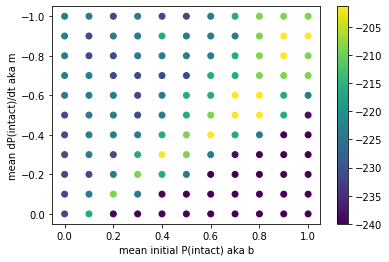

In [112]:
plt.scatter(bs, ms, c=mean_logLs_new)
plt.xlabel('mean initial P(intact) aka b')
plt.ylabel('mean dP(intact)/dt aka m')
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

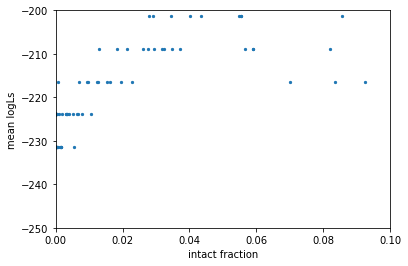

In [123]:
df.loc[:, "mean_intact_fracs"] = df.intact_fracs.apply(lambda x: np.mean(x))
plt.scatter(df.mean_intact_fracs, mean_logLs, s=5)
plt.ylabel('mean logLs')
plt.xlabel('intact fraction')
plt.xlim(0, 0.1)
plt.ylim(-250, -200)
plt.show()

### Investigate multimodal logLs for high-magnitude 0-approx lams

Specifically, the closer 0-approx lams get to 1e-12, the more multimodal, banded, and peaked their respective plots are

[695.0, 706.0, 735.0, 717.0, 636.0, 718.0, 686.0, 669.0, 685.0, 691.0, 718.0, 682.0, 655.0, 667.0, 671.0, 751.0, 745.0, 674.0, 686.0, 699.0, 696.0, 675.0, 703.0, 742.0, 693.0, 688.0, 707.0, 697.0, 682.0, 687.0, 723.0, 684.0, 700.0, 729.0, 708.0, 737.0, 665.0, 701.0, 667.0, 674.0, 658.0, 708.0, 681.0, 701.0, 688.0, 685.0, 704.0, 700.0, 695.0, 710.0, 674.0, 682.0, 692.0, 658.0, 679.0, 686.0, 637.0, 685.0, 743.0, 670.0, 667.0, 658.0, 635.0, 701.0, 687.0, 677.0, 683.0, 683.0, 664.0, 639.0, 663.0, 674.0, 707.0, 678.0, 702.0, 729.0, 667.0, 711.0, 670.0, 686.0, 682.0, 727.0, 716.0, 675.0, 689.0, 645.0, 708.0, 681.0, 715.0, 687.0, 726.0, 683.0, 707.0, 698.0, 688.0, 706.0, 690.0, 663.0, 691.0, 699.0]
[-824.3307697249828, -269.36697723504057, -294.28223714113517, -474.7695983010831, -785.1234345349391, -509.13416485013005, -267.0205909821013, -470.9727823880294, -479.25034588481606, -821.0299422990828, -482.0564825407324, -264.9012956774199, -797.2691513357873, -476.5832482020095, -478.290960911

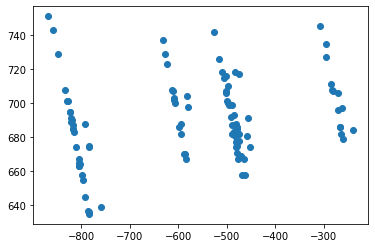

In [147]:
# Case A zero bins included
ones = []
bin_n = 6
for x in df.loc[(ms==-1.0)&(bs==0.6)]['lams'][bin_n]:
    ones.append(x[1])
print(ones)
print(df.loc[(ms==-1.0)&(bs==0.6)]['fixed_logLs'][bin_n])
plt.scatter(df.loc[(ms==-1.0)&(bs==0.6)]['fixed_logLs'][bin_n], ones)
#plt.xlim(-550, -400)
plt.show()

In [148]:
test_df = df.loc[(ms==-1.0)&(bs==0.6)]['fixed_logLs'][6]
args_a = [i[0] for i in np.argwhere(np.array(test_df) < -700)]
args_b = [i[0] for i in np.argwhere((np.array(test_df) > -700) & (np.array(test_df) < -550))]
args_c = [i[0] for i in np.argwhere((np.array(test_df) > -550) & (np.array(test_df) < -400))]
args_d = [i[0] for i in np.argwhere(np.array(test_df) > -350)]
print(args_a, len(args_a))
print(args_b, len(args_b))
print(args_c, len(args_c))
print(args_d, len(args_d))

[0, 4, 9, 12, 15, 17, 21, 25, 33, 36, 37, 38, 40, 45, 48, 50, 56, 57, 58, 62, 63, 68, 69, 70, 84, 85, 86, 89, 91, 96, 97] 31
[18, 22, 26, 28, 30, 35, 41, 44, 46, 47, 59, 60, 74, 75, 78, 93] 16
[3, 5, 7, 8, 10, 13, 14, 19, 23, 24, 29, 32, 39, 42, 43, 49, 51, 52, 53, 61, 64, 65, 66, 67, 71, 73, 76, 79, 80, 82, 83, 87, 88, 90, 92, 94, 95, 98, 99] 39
[1, 2, 6, 11, 16, 20, 27, 31, 34, 54, 55, 72, 77, 81] 14


In [156]:
for arg in args_a:
    print(df.loc[(ms==-1.0)&(bs==0.6)]['lams'][bin_n][arg][1:])
    

[695.0, 42.0, 1e-12, 1e-12, 1e-12]
[636.0, 53.0, 1e-12, 1e-12, 1e-12]
[691.0, 53.0, 1e-12, 1e-12, 1e-12]
[655.0, 52.0, 1e-12, 1e-12, 1e-12]
[751.0, 29.0, 1e-12, 1e-12, 1e-12]
[674.0, 38.0, 1e-12, 1e-12, 1e-12]
[675.0, 39.0, 1e-12, 1e-12, 1.0]
[688.0, 52.0, 1e-12, 1e-12, 1.0]
[729.0, 59.0, 1e-12, 1e-12, 1e-12]
[665.0, 44.0, 1e-12, 1e-12, 1e-12]
[701.0, 35.0, 1e-12, 1e-12, 1e-12]
[667.0, 56.0, 1e-12, 1e-12, 1e-12]
[658.0, 47.0, 1e-12, 1e-12, 1e-12]
[685.0, 55.0, 1e-12, 1e-12, 1e-12]
[695.0, 50.0, 1e-12, 1e-12, 1e-12]
[674.0, 42.0, 1e-12, 1e-12, 1.0]
[637.0, 38.0, 1e-12, 1e-12, 1e-12]
[685.0, 48.0, 1e-12, 1e-12, 1e-12]
[743.0, 39.0, 1e-12, 1e-12, 1e-12]
[635.0, 46.0, 1e-12, 1e-12, 1e-12]
[701.0, 50.0, 1e-12, 1e-12, 1e-12]
[664.0, 44.0, 1e-12, 1e-12, 1e-12]
[639.0, 55.0, 1e-12, 1e-12, 1.0]
[663.0, 36.0, 1e-12, 1e-12, 1e-12]
[689.0, 40.0, 1e-12, 1e-12, 1e-12]
[645.0, 37.0, 1e-12, 1e-12, 1e-12]
[708.0, 64.0, 1e-12, 1e-12, 1e-12]
[687.0, 48.0, 1e-12, 1e-12, 1e-12]
[683.0, 49.0, 1e-12, 1e-12, 

In [151]:
for arg in args_c:
    print(df.loc[(ms==-1.0)&(bs==0.6)]['lams'][bin_n][arg][1:])
    

[717.0, 42.0, 2.0, 1e-12, 1.0]
[718.0, 57.0, 1.0, 1e-12, 1e-12]
[669.0, 36.0, 2.0, 1e-12, 1e-12]
[685.0, 46.0, 2.0, 1e-12, 1e-12]
[718.0, 51.0, 1.0, 1e-12, 1.0]
[667.0, 37.0, 1.0, 1e-12, 1e-12]
[671.0, 40.0, 1.0, 1e-12, 1e-12]
[699.0, 49.0, 2.0, 1e-12, 1e-12]
[742.0, 39.0, 1.0, 1e-12, 1e-12]
[693.0, 50.0, 2.0, 1e-12, 1e-12]
[687.0, 43.0, 1.0, 1e-12, 1e-12]
[700.0, 48.0, 1.0, 1e-12, 1e-12]
[674.0, 49.0, 1.0, 1e-12, 1.0]
[681.0, 45.0, 1.0, 1e-12, 1.0]
[701.0, 39.0, 1.0, 1e-12, 1e-12]
[710.0, 36.0, 2.0, 1e-12, 1e-12]
[682.0, 32.0, 1.0, 1e-12, 1e-12]
[692.0, 49.0, 1.0, 1e-12, 1e-12]
[658.0, 57.0, 1.0, 1e-12, 1e-12]
[658.0, 47.0, 2.0, 1e-12, 1e-12]
[687.0, 37.0, 2.0, 1e-12, 1e-12]
[677.0, 47.0, 1.0, 1e-12, 1e-12]
[683.0, 45.0, 1.0, 1e-12, 1e-12]
[683.0, 43.0, 1.0, 1e-12, 1e-12]
[674.0, 41.0, 1.0, 1e-12, 1e-12]
[678.0, 48.0, 2.0, 1e-12, 1e-12]
[667.0, 62.0, 3.0, 1e-12, 1e-12]
[686.0, 48.0, 2.0, 1e-12, 1e-12]
[682.0, 59.0, 3.0, 1e-12, 1e-12]
[716.0, 36.0, 2.0, 1e-12, 1e-12]
[675.0, 49.0, 1.0,

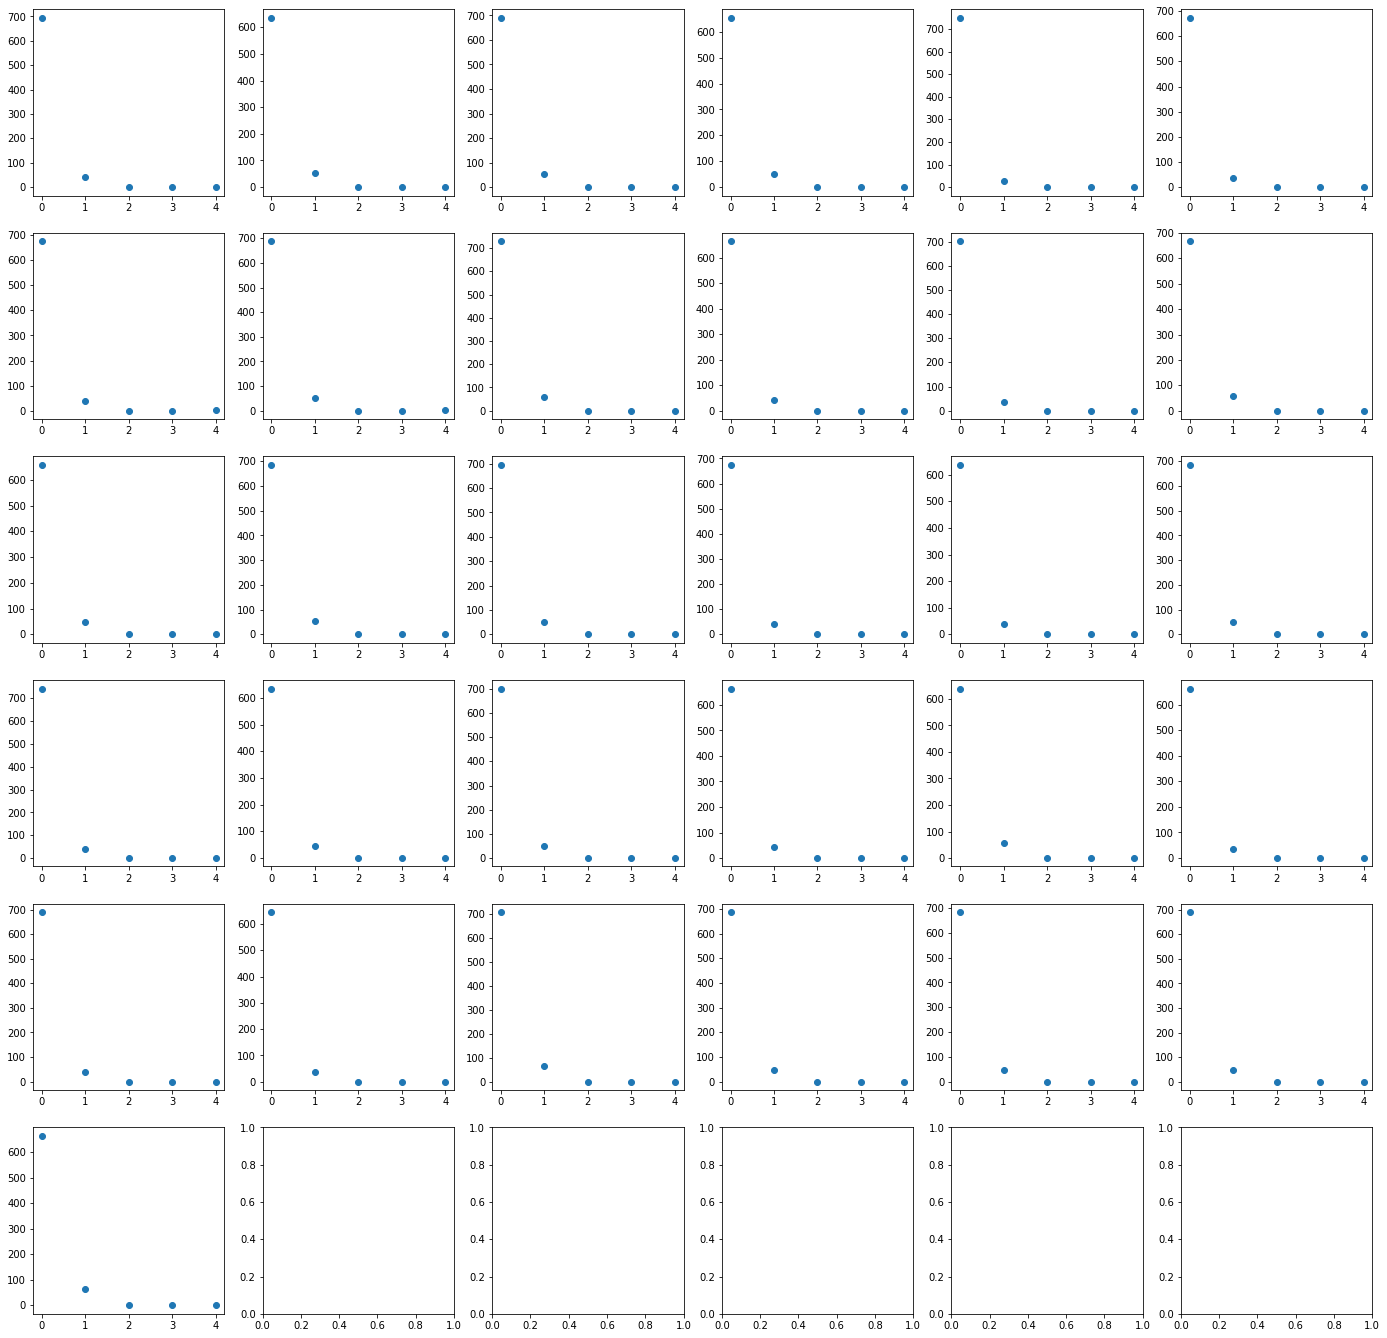

In [158]:
len_arg = len(args_a)
fig, axes = plt.subplots(ncols=6, nrows=np.ceil(len_arg/6).astype(int), figsize=[24,24])
axes = axes.flatten()
for i, j in enumerate(args_a):
    ax = axes[i]
    item = df.loc[(ms==-1.0)&(bs==0.6)]['lams'][bin_n][j][1:]
    ax.scatter(pd.Series(item).index, item)
plt.show()

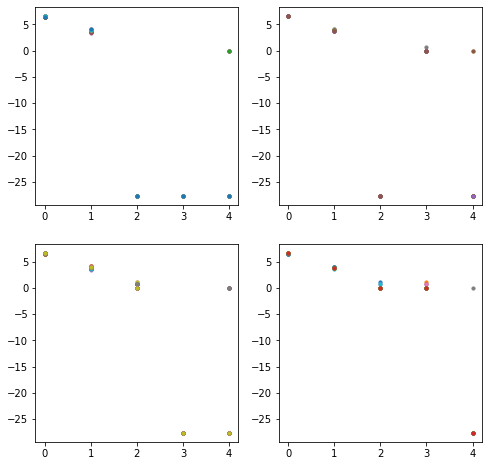

In [171]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=[8,8])
axes = axes.flatten()
for i, j in enumerate([args_a, args_b, args_c, args_d]):
    ax = axes[i]
    for arg in j:
        item = df.loc[(ms==-1.0)&(bs==0.6)]['lams'][bin_n][arg][1:]
        ax.scatter(pd.Series(item).index, np.log(item), s=10)
plt.show()

So the four populations in this multimodal case simply come from four different ways of having the 1e-12 lambda count: in the 2/3/4 bins; in the 2/4 bins; in the 3/4 bins; and in the 4 bin only. Mystery solved!

### Posterior m's and b's for best logL cases

Find all cases where max_logL - logL <= threshold across the 12100 simulation sets, keeping info of (m, b). Find all {m_i, b_i} where this is true, and how often each pair gets us a “good” logL. Plot posteriors of m and b (ie. histograms of m_i and b_i), where m_i and b_i are marginal coordinates of each cell. 

In [190]:
# find good logL cases
max_logL = np.max(mean_logLs)
print(max_logL)
max_logLs = []
for i in df.logLs_nonzero:
    max_logLs.append(np.max(i))
print(max_logLs)
print(np.max(max_logLs))

-195.6631179153636
[-186.22036386155898, -186.2207635491537, -190.30477167786316, -182.58931450853763, -175.28599210768525, -189.36111095853056, -195.0331101794027, -185.1034121795792, -155.5283715082541, -174.04011332455423, -161.54536243415447, -173.2415549625011, -177.66457288145645, -181.0735125598421, -186.96694605494744, -191.56033413714377, -193.7060104397714, -174.58008155080103, -183.8933223752597, -163.36501777067326, -167.63243982813702, -157.2712206534671, -190.38465517981948, -183.44535080704057, -178.75586295213222, -187.42586327708418, -178.1861748815967, -186.03574700396265, -182.86484700829996, -169.32416738791915, -148.77483534358618, -170.6298470733946, -159.40199102300537, -182.01467107110236, -191.89548326057954, -187.08022728085965, -178.34207684203653, -179.90197860058623, -184.01219357981986, -188.4773852120593, -166.90241144366175, -167.02779233182457, -169.98423702901042, -170.52983128970976, -191.70925555242937, -189.7747431925616, -196.16148210143447, -192.3

I guess I should take the true maximum across all simulations rather than the artificially binned maximum, right? -149 it is.

In [191]:
df

,ms,bs,intact_fracs,logLs,lams,geometric_lams,geometric_logLs,lams_nonzero,logLs_nonzero
0,-1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-861.3326564321698, -825.8876440117946, -825....","[[19178.0, 749.0, 42.0, 1e-12, 1e-12, 1e-12], ...","[[18627.0, 1223.0, 119.0, 1e-12, 1e-12, 1e-12]...","[-1261.4969915537633, -1250.2596228659804, -12...","[[749.0, 42.0, 1e-12, 1e-12, 1e-12], [697.0, 6...","[-269.38485861950994, -234.75110823126832, -23..."
1,-1.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-799.328925833771, -777.0103471419387, -803.7...","[[19274.0, 656.0, 39.0, 1e-12, 1e-12, 1e-12], ...","[[18690.0, 1166.0, 113.0, 1e-12, 1e-12, 1e-12]...","[-1209.4231169020752, -1219.629124541648, -125...","[[656.0, 39.0, 1e-12, 1e-12, 1e-12], [623.0, 4...","[-209.51344467519354, -187.68825932508096, -21..."
2,-1.0,0.2,"[0.0, 0.0, 5.00776203114828e-05, 0.0, 5.007762...","[-805.1386708963076, -827.6047739947156, -832....","[[19255.0, 667.0, 47.0, 1e-12, 1e-12, 1e-12], ...","[[18638.0, 1207.0, 124.0, 1e-12, 1e-12, 1e-12]...","[-1251.0086758749592, -1220.2300831235755, -12...","[[667.0, 47.0, 1e-12, 1e-12, 1e-12], [696.0, 3...","[-214.94002223953808, -237.06861725314067, -24..."
3,-1.0,0.3,"[0.0001001552406229656, 0.0001502328609344484,...","[-808.4876059606244, -822.7657963210123, -816....","[[19243.0, 672.0, 54.0, 1e-12, 1e-12, 1e-12], ...","[[18684.0, 1157.0, 128.0, 1e-12, 1e-12, 1e-12]...","[-1211.2671824864144, -1244.2059895874816, -12...","[[672.0, 54.0, 1e-12, 1e-12, 1e-12], [692.0, 4...","[-218.03709966773684, -232.18649579964122, -22..."
4,-1.0,0.4,"[0.0006510090640492763, 0.0004006209624918624,...","[-477.2874397003105, -788.1722031988063, -773....","[[19251.0, 671.0, 46.0, 1.0, 1e-12, 1e-12], [1...","[[18618.0, 1204.0, 146.0, 1.0, 1e-12, 1e-12], ...","[-932.8145577654657, -1209.7027296547874, -120...","[[671.0, 46.0, 1.0, 1e-12, 1e-12], [640.0, 58....","[-218.5779404881279, -198.29749256198883, -184..."
...,...,...,...,...,...,...,...,...,...
116,0.0,0.6,"[0.5964244579097602, 0.6007812108768591, 0.596...","[-502.3173500269684, -558.7062623889922, -520....","[[18794.0, 701.0, 271.0, 123.0, 61.0, 15.0], [...","[[18127.0, 963.0, 376.0, 216.0, 188.0, 78.0], ...","[-1083.8886428193034, -1138.0793238613696, -11...","[[701.0, 271.0, 123.0, 61.0, 15.0], [724.0, 29...","[-477.11708344989785, -530.2690308215658, -493..."
117,0.0,0.7,"[0.6946266713405779, 0.7012369172216937, 0.696...","[-620.6107843375355, -579.68334728838, -591.55...","[[18663.0, 725.0, 308.0, 176.0, 79.0, 16.0], [...","[[18004.0, 909.0, 418.0, 297.0, 226.0, 101.0],...","[-1227.8254671542775, -1200.6712207379887, -11...","[[725.0, 308.0, 176.0, 79.0, 16.0], [726.0, 31...","[-588.9433689315335, -550.0418801407568, -561...."
118,0.0,0.8,"[0.8031448745555612, 0.8018428564274626, 0.799...","[-710.0745076737753, -699.3343845145812, -608....","[[18563.0, 726.0, 371.0, 183.0, 93.0, 27.0], [...","[[17908.0, 857.0, 483.0, 322.0, 248.0, 124.0],...","[-1324.9824728296974, -1348.7435038027836, -12...","[[726.0, 371.0, 183.0, 93.0, 27.0], [775.0, 33...","[-672.8193456746035, -662.372104505843, -578.1..."
119,0.0,0.9,"[0.9013971656066904, 0.8966397916770995, 0.902...","[-784.2720195137433, -766.9538395706194, -838....","[[18475.0, 780.0, 390.0, 197.0, 96.0, 27.0], [...","[[17736.0, 891.0, 510.0, 376.0, 272.0, 149.0],...","[-1491.6045251895155, -1456.4168055744135, -15...","[[780.0, 390.0, 197.0, 96.0, 27.0], [775.0, 36...","[-741.6280538894414, -725.6361861578342, -791...."


In [198]:
max_logL = np.max(max_logLs)
for i, l in enumerate(df.logLs_nonzero):
    for j in l:
        if max_logL - j < 10:
            print(j, df.ms[i], df.bs[i])

-155.5283715082541 -1.0 0.8
-157.2712206534671 -0.9 1.0
-148.77483534358618 -0.8 0.8
-155.49186884580504 -0.2 0.3
